In [1]:
#! pip install joblib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import cv2
import matplotlib.patches as patches
from lmfit import Model, Parameters
from tqdm import tqdm
from joblib import Parallel, delayed
from astropy.cosmology import FlatLambdaCDM
from scipy.constants import c
from scipy.interpolate import interp1d
import json

# COSMOLOGY USED
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
###############

In [3]:
# Gaussian function with peak, sigma and mean
def mygauss(x,mean, sig, peak):
    exp_in = (x - mean)**2/(2*sig**2)
    return peak*np.exp(-exp_in)

# Extract spectrum from a circular region from a fits cube given the center in X and Y and radius in R (pixels)
def spec_circ_aper(cube, x0, y0, R):
    Nz, Ny , Nx = np.shape(cube)
    x,y = np.arange(Nx), np.arange(Ny)
    xgrid, ygrid = np.meshgrid(x,y)
    rgrid = ((xgrid-x0)**2+(ygrid-y0)**2)**0.5
    w = np.where(rgrid < R)
    spec = np.zeros(Nz)
    for k in range(Nz):
        img = cube[k,:,:]
        spec[k] = img[w].sum()
    return spec

# Given flux, t gives luminosity
def luminosity(flux, redshift):
    d_l = cosmo.luminosity_distance(redshift)
    area = 4*np.pi*d_l.value*d_l.value
    return np.log10(flux)+np.log10(area)+2.*(24.+np.log10(3.08567802))

In [4]:
# Get the emission line locations
line_lists = json.load(open('/Users/dk24abv/work/software/line_list.json'))
opt_lines = line_lists["optical"]
print(opt_lines)

# Access the first element
element_dict = opt_lines[0]  # The first element in the JSON list

# Set variables dynamically from the dictionary
for element, value in element_dict.items():
    globals()[element] = value  # Sets the variable name as the element key

[{'HeII4685': 4685.71, 'Hbeta': 4861.333, 'OIII4959': 4958.911, 'OIII5007': 5006.843, 'FeVII5158': 5158.89, 'FeII5197': 5197.577, 'FeVII5720': 5720.7, 'NII5754': 5754.59, 'HeI5875': 5875.624, 'FeVII6087': 6087.0, 'OI6300': 6300.304, 'OI6363': 6363.776, 'NII6548': 6548.05, 'Halpha': 6562.819, 'NII6583': 6583.46, 'SII6716': 6716.081, 'SII6731': 6730.81, 'ArIII7135': 7135.79, 'OII7320': 7319.99, 'OII7330': 7330.73, 'NiII7377': 7377.83, 'ArIII7751': 7751.06}]


In [5]:
z = 0.01960 # Redshift of the target
muse_raw = fits.getdata("./raw_muse_file.fits", ext=1) # Raw MUSE cube
muse_hdr = fits.getheader("./raw_muse_file.fits", ext=1) # MUSE cube header
muse_cont = fits.getdata("./continuum_file.fits") # Continuum model

(0.0, 400.0)

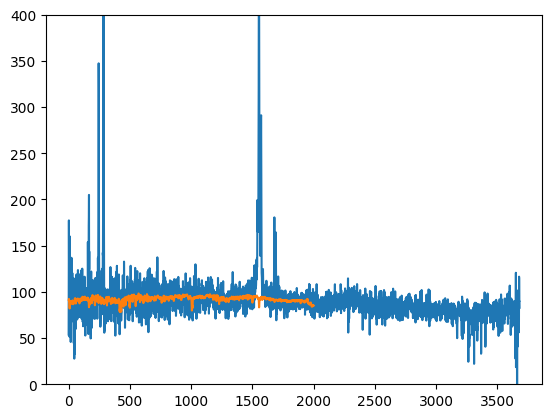

In [6]:
# Visualise how the spectrum looks like for one of the pixels

i_test,j_test = 178,146
plt.plot(muse_raw[:,j_test,i_test])
plt.plot(muse_cont[:,j_test,i_test])
plt.ylim(0,400)

In [7]:
# Make the continuum-subtracted cube to get an emission line only cube
contsub_cube = muse_raw-muse_cont
contsub_cube[np.isnan(contsub_cube)] = 0
Nz_muse,Ny_muse,Nx_muse = np.shape(contsub_cube)
muse_pscale = abs(muse_hdr["CD1_1"])*3600 # MUSE pixel scale from the header
print("MUSE pixel scale = ", muse_pscale)

MUSE pixel scale =  0.20000000000000015


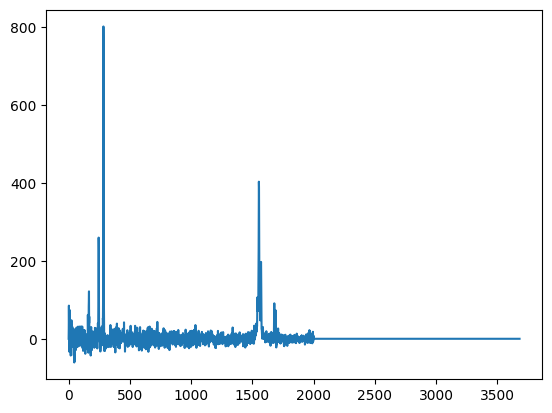

In [8]:
# Visualise the continuum-subtracted spectrum from the spectrum plotted above

plt.plot(contsub_cube[:,j_test,i_test])

In [9]:
# Get the wavelength array from MUSE headers

wl = (np.linspace(1,Nz_muse,Nz_muse)-muse_hdr["CRPIX3"])*muse_hdr["CD3_3"]+\
    muse_hdr["CRVAL3"]
wl_DR = wl/(1+z) # Wavelength array in de-redshifted space

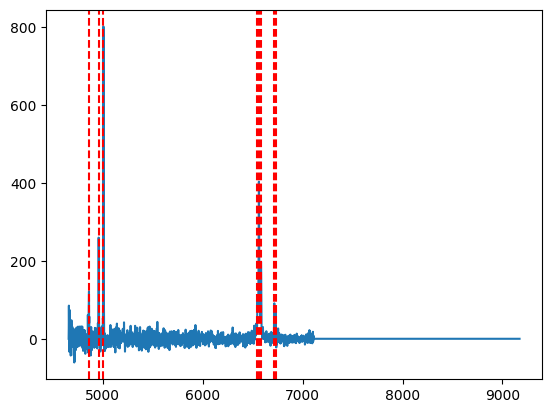

In [10]:
# Verify the wavelength array using the spectrum above. The [OIII]5007 location should match

plt.plot(wl_DR, contsub_cube[:,j_test,i_test])
for line in [Hbeta, OIII4959, OIII5007, NII6548, Halpha, NII6583, SII6716, SII6731]:
    plt.axvline(line, linestyle="--", color="red")

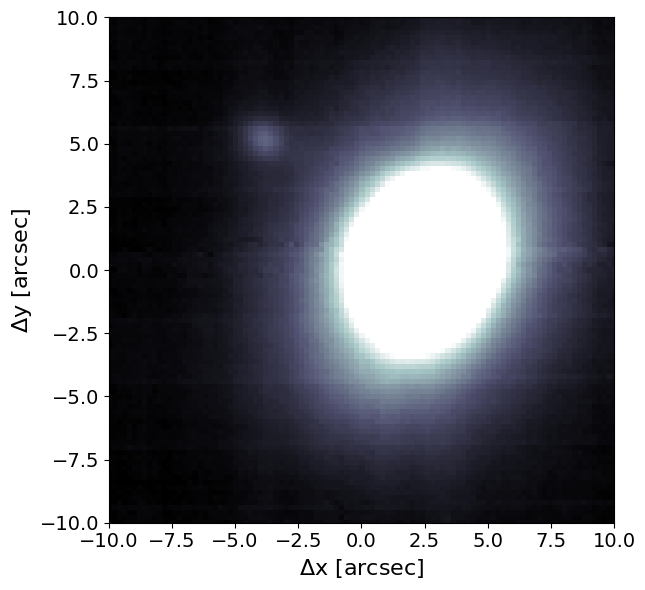

In [11]:
# Make the median MUSE image (Collapsing along the spectral axis)

fig, ax = plt.subplots(figsize=(7,6))

ax.imshow(np.sum(muse_raw[100:1000,:,:],axis=0),origin="lower",cmap='bone',
          vmin=0,vmax=8e+4,
         extent=[-muse_pscale*Nx_muse/2,muse_pscale*Nx_muse/2,-muse_pscale*Ny_muse/2,+muse_pscale*Ny_muse/2])

# Add a circular aperture patch (optional)
#aper_print = patches.Circle((0.35,-0.6),1.5, linewidth=4, edgecolor='red',facecolor="none")
#ax.add_patch(aper_print)

ax.set_xlabel("$\Delta$x [arcsec]", fontsize=16)
ax.set_ylabel("$\Delta$y [arcsec]", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
plt.tight_layout()
plt.savefig("./MUSE_median_img.png")

In [12]:
# Different functions used for modelling emission lines

def fit_func_1G(x,c1,c2,mean,sig,peak):
    cont_comp = c1 + c2*x
    line_comp = mygauss(x,mean,sig,peak)
    return cont_comp + line_comp

def fit_func_2G(x,c1,c2,mean1,sig1,peak1,mean2,sig2,peak2):
    cont_comp = c1 + c2*x
    line_comp1 = mygauss(x,mean1,sig1,peak1)
    line_comp2 = mygauss(x,mean2,sig2,peak2)
    return cont_comp + line_comp1 + line_comp2

def func_oiii_hb(x,c1, c2, mean, sig, peak_oiii, peak_hb):
    comp_cont = c1 + c2*x
    comp_oiii5007 = mygauss(x,mean,sig,peak_oiii)
    comp_oiii4959 = mygauss(x,mean+(OIII4959-OIII5007),sig,peak_oiii/3)
    comp_hbeta = mygauss(x,mean+(Hbeta-OIII5007),sig,peak_hb)
    full_model = comp_cont+comp_oiii5007+comp_oiii4959+comp_hbeta
    return full_model

def func_oiii_hb_2G(x,c1,c2,mean1,sig1,peak1_oiii,peak1_hb,mean2,sig2,peak2_oiii,peak2_hb,mean_blr,sig_blr,peak_blr):
    comp_cont = c1 + c2*x
    comp_oiii5007 = mygauss(x,mean1,sig1,peak1_oiii)
    comp_oiii4959 = mygauss(x,mean1+(OIII4959-OIII5007),sig1,peak1_oiii/3)
    comp_hbeta = mygauss(x,mean1+(Hbeta-OIII5007),sig1,peak1_hb)
    comp_oiii5007b = mygauss(x,mean2,sig2,peak2_oiii)
    comp_oiii4959b = mygauss(x,mean2+(OIII4959-OIII5007),sig2,peak2_oiii/3)
    comp_hbetab = mygauss(x,mean2+(Hbeta-OIII5007),sig2,peak2_hb)
    comp_blr = mygauss(x,mean_blr,sig_blr,peak_blr)
    narrow_model = comp_oiii5007+comp_oiii4959+comp_hbeta
    broad_model = comp_oiii5007b+comp_oiii4959b+comp_hbetab
    full_model = comp_cont+narrow_model+broad_model+comp_blr
    return full_model

def func_nii_ha(x,c1,c2,mean,sig,peak_ha,peak_nii):
    comp_cont = c1 + c2*x
    comp_halpha = mygauss(x,mean,sig,peak_ha)
    comp_nii6583 = mygauss(x,mean+(NII6583-Halpha),sig,peak_nii)
    comp_nii6548 = mygauss(x,mean+(NII6548-Halpha),sig,peak_nii/3)
    full_model = comp_cont+comp_halpha+comp_nii6583+comp_nii6548
    return full_model

def func_nii_ha_2G(x,c1,c2,mean1,sig1,peak1_ha,peak1_nii,mean2,sig2,peak2_ha,peak2_nii,mean_blr,sig_blr,peak_blr):
    comp_cont = c1 + c2*x
    comp_ha_1 = mygauss(x,mean1,sig1,peak1_ha)
    comp_nii6583_1 = mygauss(x,mean1+(NII6583-Halpha),sig1,peak1_nii)
    comp_nii6548_1 = mygauss(x,mean1+(NII6548-Halpha),sig1,peak1_nii/3)
    
    comp_ha_2 = mygauss(x,mean2,sig2,peak2_ha)
    comp_nii6583_2 = mygauss(x,mean2+(NII6583-Halpha),sig2,peak2_nii)
    comp_nii6548_2 = mygauss(x,mean2+(NII6548-Halpha),sig2,peak2_nii/3)
    
    comp_blr = mygauss(x,mean_blr,sig_blr,peak_blr)
    full_model = comp_cont+comp_ha_1+comp_nii6583_1+comp_nii6548_1+comp_ha_2+comp_nii6583_2+comp_nii6548_2+comp_blr
    return full_model

def func_sii(x,c1,c2,mean,sig,peak_sii6716,peak_sii6731):
    comp_cont = c1 + c2*x
    comp_sii6716 = mygauss(x,mean,sig,peak_sii6716)
    comp_sii6731 = mygauss(x,mean+(SII6731-SII6716),sig,peak_sii6731)
    full_model = comp_cont+comp_sii6716+comp_sii6731
    return full_model

def func_sii_2G(x,c1,c2,mean1,sig1,peak1_sii6716,peak1_sii6731,mean2,sig2,peak2_sii6716,peak2_sii6731):
    comp_cont = c1 + c2*x
    comp_sii6716 = mygauss(x,mean1,sig1,peak1_sii6716)
    comp_sii6731 = mygauss(x,mean1+(SII6731-SII6716),sig1,peak1_sii6731)
    comp_sii6716b = mygauss(x,mean2,sig2,peak2_sii6716)
    comp_sii6731b = mygauss(x,mean2+(SII6731-SII6716),sig2,peak2_sii6731)
    full_model = comp_cont+comp_sii6716+comp_sii6731+comp_sii6716b+comp_sii6731b
    return full_model

def compute_v_percentiles(wavelength, flux, line_center_rest):
    """
    Compute v10, v50, v90 for an emission line in a spectrum.

    Parameters:
    - wavelength: array of wavelengths [in Angstroms]
    - flux: array of fluxes (same length as wavelength)
    - line_center_rest: rest-frame wavelength of the emission line [in Angstroms]

    Returns:
    - v10, v50, v90: velocities in km/s at 10%, 50%, 90% cumulative line flux
    """
    # Ensure arrays are sorted by wavelength
    sorted_indices = np.argsort(wavelength)
    wavelength = wavelength[sorted_indices]
    flux = flux[sorted_indices]

    # Subtract continuum if needed (optional: here a simple median is used)
    continuum = np.median(flux)
    line_flux = flux - continuum
    line_flux[line_flux < 0] = 0  # set negative values to zero

    # Compute cumulative flux
    cum_flux = np.cumsum(line_flux)
    cum_flux /= cum_flux[-1]  # normalize to 1

    # Interpolate wavelength at which cumulative flux reaches 0.1, 0.5, 0.9
    f_interp = interp1d(cum_flux, wavelength, bounds_error=False, fill_value="extrapolate")
    wl10 = f_interp(0.1)
    wl50 = f_interp(0.5)
    wl90 = f_interp(0.9)

    # Convert wavelengths to velocity offsets from the line center
    def wl_to_v(wl): return ((wl - line_center_rest) / line_center_rest) * c / 1000  # km/s

    v10 = wl_to_v(wl10)
    v50 = wl_to_v(wl50)
    v90 = wl_to_v(wl90)

    return v10, v50, v90

In [13]:
# Create the list of pixel coordinates to process
coords = [(j, i) for j in range(1, Ny_muse-1) for i in range(1, Nx_muse-1)]
#coords = [(j, i) for j in range(145, 165) for i in range(165, 185)]

## Fit [OIII] and Hbeta

In [14]:
filt_oiii = np.where((wl_DR>4800)&(wl_DR<5050))
wl_oiii = wl_DR[filt_oiii]
cube_oiii = contsub_cube[filt_oiii,:,:][0,:,:,:]

Fitting pixels: 100%|█████████████████| 103683/103683 [1:15:58<00:00, 22.74it/s]


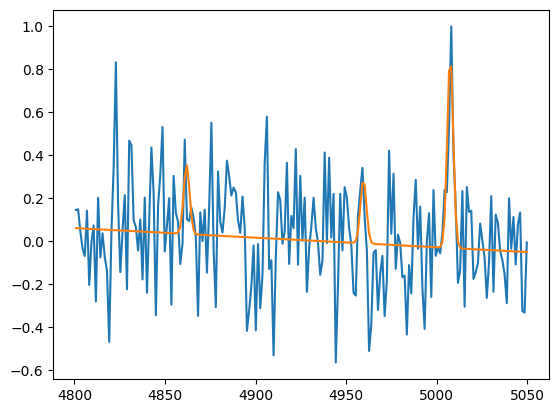

In [15]:
# Fit a one Gaussian model to OIII & Hbeta
oiii_c1_1G = np.zeros((Ny_muse,Nx_muse))
oiii_c2_1G = np.zeros((Ny_muse,Nx_muse))
oiii_wave_1G = np.zeros((Ny_muse,Nx_muse))
oiii_sig_1G = np.zeros((Ny_muse,Nx_muse))
oiii_flux_1G = np.zeros((Ny_muse,Nx_muse))
Hb_flux_1G = np.zeros((Ny_muse,Nx_muse))
bic_oiii_1G = np.zeros((Ny_muse, Nx_muse))

model_oiii = Model(func_oiii_hb)
params_oiii = Parameters()
params_oiii.add('c1', value=0)
params_oiii.add('c2', value=0)
params_oiii.add('mean', value=5006.843, min=4990, max=5020)
params_oiii.add('sig', value=2, min=0)
params_oiii.add('peak_oiii', value=1, min=0)
params_oiii.add('peak_hb', value=1, min=0)

def fit_pixel_oiii_1G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_oiii[:,j,i]+cube_oiii[:,j-1,i]+cube_oiii[:,j+1,i]+cube_oiii[:,j,i-1]+cube_oiii[:,j,i+1])/5 
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_oiii = model_oiii.fit(spec_norm, params_oiii, x=wl_oiii, weights=1)
    return (
        fit_oiii.params["c1"].value,
        fit_oiii.params["c2"].value,
        fit_oiii.params["mean"].value,
        fit_oiii.params["sig"].value,
        np.sqrt(2*np.pi)*fit_oiii.params["sig"].value*fit_oiii.params["peak_oiii"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_oiii.params["sig"].value*fit_oiii.params["peak_hb"].value*1e-20*np.max(spec),
        fit_oiii.bic
    )

# Parallel with tqdm
fit_oiii1G_models = True
if fit_oiii1G_models == True:
    results_oiii_1G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_oiii_1G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

visualise_spec_oiii1G = True
# Visualise the spectral fit using this section
if visualise_spec_oiii1G == True:
    i,j = 233, 153
    spec = (cube_oiii[:,j,i]+cube_oiii[:,j-1,i]+cube_oiii[:,j+1,i]+cube_oiii[:,j,i-1]+cube_oiii[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm    = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_oiii = model_oiii.fit(spec_norm, params_oiii, x=wl_oiii, weights=1)
    plt.plot(wl_oiii, cube_oiii[:,j,i]/np.max(cube_oiii[:,j,i]))
    plt.plot(wl_oiii, fit_oiii.best_fit)

In [16]:
# Fill the output arrays
idx = 0
for j, i in coords:
    oiii_c1_1G[j,i],oiii_c2_1G[j,i], oiii_wave_1G[j,i], oiii_sig_1G[j,i], oiii_flux_1G[j,i], Hb_flux_1G[j,i], bic_oiii_1G[j,i] = results_oiii_1G[idx]
    idx += 1

Fitting pixels:  15%|██▏            | 15488/103683 [8:58:03<17:16:49,  1.42it/s]/var/folders/zd/5tclx9553z5cr_l9rz0l5svc0000gr/T/ipykernel_72792/2520616825.py:3: RuntimeWarning: divide by zero encountered in divide
  exp_in = (x - mean)**2/(2*sig**2)
Fitting pixels: 100%|████████████████| 103683/103683 [34:43:18<00:00,  1.21s/it]


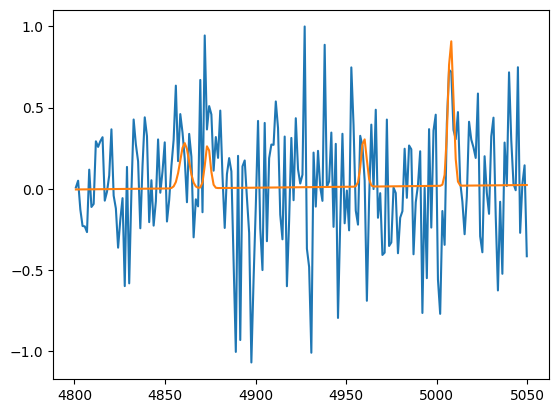

In [17]:
# Fit a two Gaussian model to OIII & Hbeta
oiii_c1_2G = np.zeros((Ny_muse,Nx_muse))
oiii_c2_2G = np.zeros((Ny_muse,Nx_muse))
oiii_wave1_2G = np.zeros((Ny_muse,Nx_muse))
oiii_sig1_2G = np.zeros((Ny_muse,Nx_muse))
oiii_flux1_2G = np.zeros((Ny_muse,Nx_muse))
Hb_flux1_2G = np.zeros((Ny_muse,Nx_muse))
oiii_wave2_2G = np.zeros((Ny_muse,Nx_muse))
oiii_sig2_2G = np.zeros((Ny_muse,Nx_muse))
oiii_flux2_2G = np.zeros((Ny_muse,Nx_muse))
Hb_flux2_2G = np.zeros((Ny_muse,Nx_muse))
Hb_blr_wave_2G = np.zeros((Ny_muse,Nx_muse))
Hb_blr_sig_2G = np.zeros((Ny_muse,Nx_muse))
Hb_blr_flux_2G = np.zeros((Ny_muse,Nx_muse))
bic_oiii_2G = np.zeros((Ny_muse, Nx_muse))

model_oiii2G = Model(func_oiii_hb_2G)
params_oiii2G = Parameters()
params_oiii2G.add('c1', value=0)
params_oiii2G.add('c2', value=0)
params_oiii2G.add('mean1', value=5006.843, min=4990, max=5020)
params_oiii2G.add('sig1', value=1.5, min=0)
params_oiii2G.add('peak1_oiii', value=1, min=0)
params_oiii2G.add('peak1_hb', value=1, min=0)
params_oiii2G.add('mean2', value=5006.843, min=4990, max=5020)
params_oiii2G.add('sig2', value=3, min=0)
params_oiii2G.add('peak2_oiii', value=1, min=0)
params_oiii2G.add('peak2_hb', value=1, min=0)
params_oiii2G.add('mean_blr', value=4861, min=4800, max=4900)
params_oiii2G.add('sig_blr', value=30, min=0)
params_oiii2G.add('peak_blr', value=0.1, min=0)

def fit_pixel_oiii_2G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_oiii[:,j,i]+cube_oiii[:,j-1,i]+cube_oiii[:,j+1,i]+cube_oiii[:,j,i-1]+cube_oiii[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_oiii = model_oiii2G.fit(spec_norm, params_oiii2G, x=wl_oiii, weights=1)
    return (
        fit_oiii.params["c1"].value,
        fit_oiii.params["c2"].value,
        fit_oiii.params["mean1"].value,
        fit_oiii.params["sig1"].value,
        np.sqrt(2*np.pi)*fit_oiii.params["sig1"].value*fit_oiii.params["peak1_oiii"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_oiii.params["sig1"].value*fit_oiii.params["peak1_hb"].value*1e-20*np.max(spec),
        fit_oiii.params["mean2"].value,
        fit_oiii.params["sig2"].value,
        np.sqrt(2*np.pi)*fit_oiii.params["sig2"].value*fit_oiii.params["peak2_oiii"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_oiii.params["sig2"].value*fit_oiii.params["peak2_hb"].value*1e-20*np.max(spec),
        fit_oiii.params["mean_blr"].value,
        fit_oiii.params["sig_blr"].value,
        np.sqrt(2*np.pi)*fit_oiii.params["sig_blr"].value*fit_oiii.params["peak_blr"].value*1e-20*np.max(spec),
        fit_oiii.bic
    )

# Parallel with tqdm
fit_oiii2G_models = True
if fit_oiii2G_models == True:
    results_oiii_2G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_oiii_2G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

# Visualise the spectral fit using this section
visualise_spec_oiii2G = True
if visualise_spec_oiii2G == True:
    i,j = 226, 144
    spec = (cube_oiii[:,j,i]+cube_oiii[:,j-1,i]+cube_oiii[:,j+1,i]+cube_oiii[:,j,i-1]+cube_oiii[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_oiii2G = model_oiii2G.fit(spec_norm, params_oiii2G, x=wl_oiii, weights=1)
    plt.plot(wl_oiii, cube_oiii[:,j,i]/np.max(cube_oiii[:,j,i]))
    plt.plot(wl_oiii, fit_oiii2G.best_fit)
    fit_oiii2G.params

In [18]:
# Fill the output arrays
idx = 0
for j, i in coords:
    oiii_c1_2G[j,i],oiii_c2_2G[j,i],oiii_wave1_2G[j,i], oiii_sig1_2G[j,i], oiii_flux1_2G[j,i], Hb_flux1_2G[j,i], oiii_wave2_2G[j,i], oiii_sig2_2G[j,i], oiii_flux2_2G[j,i], Hb_flux2_2G[j,i], Hb_blr_wave_2G[j,i], Hb_blr_sig_2G[j,i], Hb_blr_flux_2G[j,i], bic_oiii_2G[j,i] = results_oiii_2G[idx]
    idx += 1 

## Fit H-alpha complex|

In [19]:
filt_ha = np.where((wl_DR>6480)&(wl_DR<6650))
wl_ha = wl_DR[filt_ha]
cube_ha = contsub_cube[filt_ha,:,:][0,:,:,:]
print(np.shape(cube_ha))

(139, 323, 325)


Fitting pixels: 100%|███████████████████| 103683/103683 [52:40<00:00, 32.81it/s]


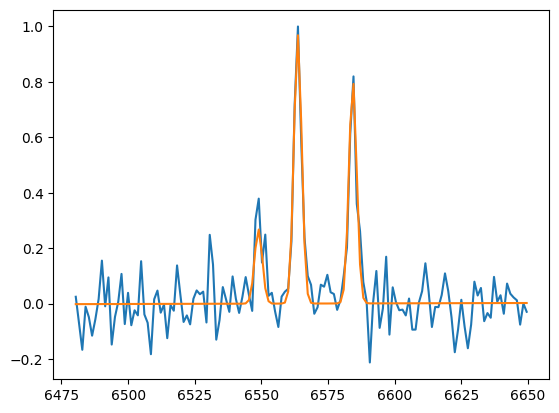

In [20]:
# Fit a one Gaussian model to NII & Halpha
ha_c1_1G = np.zeros((Ny_muse,Nx_muse))
ha_c2_1G = np.zeros((Ny_muse,Nx_muse))
ha_wave_1G = np.zeros((Ny_muse,Nx_muse))
ha_sig_1G = np.zeros((Ny_muse,Nx_muse))
ha_flux_1G = np.zeros((Ny_muse,Nx_muse))
nii6585_flux_1G = np.zeros((Ny_muse,Nx_muse))
bic_ha_1G = np.zeros((Ny_muse, Nx_muse))

model_ha = Model(func_nii_ha)
params_ha = Parameters()
params_ha.add('c1', value=0)
params_ha.add('c2', value=0)
params_ha.add('mean', value=6562, min=6555, max=6575)
params_ha.add('sig', value=2, min=0)
params_ha.add('peak_ha', value=1, min=0)
params_ha.add('peak_nii', value=0.5, min=0)

def fit_pixel_ha_1G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_ha[:,j,i]+cube_ha[:,j-1,i]+cube_ha[:,j+1,i]+cube_ha[:,j,i-1]+cube_ha[:,j,i+1])/5 
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_ha = model_ha.fit(spec_norm, params_ha, x=wl_ha, weights=1)
    return (
        fit_ha.params["c1"].value,
        fit_ha.params["c2"].value,
        fit_ha.params["mean"].value,
        fit_ha.params["sig"].value,
        np.sqrt(2*np.pi)*fit_ha.params["sig"].value*fit_ha.params["peak_ha"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_ha.params["sig"].value*fit_ha.params["peak_nii"].value*1e-20*np.max(spec),
        fit_ha.bic
    )

fit_Ha_1G_models = True
if fit_Ha_1G_models == True:
    # Parallel with tqdm
    results_ha_1G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_ha_1G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

# Visualise the spectral fit using this section
visualise_Ha_1G = True
if visualise_Ha_1G == True:
    i,j = 233, 152
    spec = (cube_ha[:,j,i]+cube_ha[:,j-1,i]+cube_ha[:,j+1,i]+cube_ha[:,j,i-1]+cube_ha[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_ha = model_ha.fit(spec_norm, params_ha, x=wl_ha, weights=1)
    plt.plot(wl_ha, spec_norm)
    plt.plot(wl_ha, fit_ha.best_fit)

In [21]:
# Fill the output arrays
idx = 0
for j, i in coords:
    ha_c1_1G[j,i],ha_c2_1G[j,i],ha_wave_1G[j,i], ha_sig_1G[j,i], ha_flux_1G[j,i], nii6585_flux_1G[j,i],bic_ha_1G[j,i] = results_ha_1G[idx]
    idx += 1

Fitting pixels:  24%|███▌           | 24481/103683 [5:19:49<14:42:38,  1.50it/s]/var/folders/zd/5tclx9553z5cr_l9rz0l5svc0000gr/T/ipykernel_72792/2520616825.py:3: RuntimeWarning: divide by zero encountered in divide
  exp_in = (x - mean)**2/(2*sig**2)
Fitting pixels: 100%|████████████████| 103683/103683 [30:06:28<00:00,  1.05s/it]


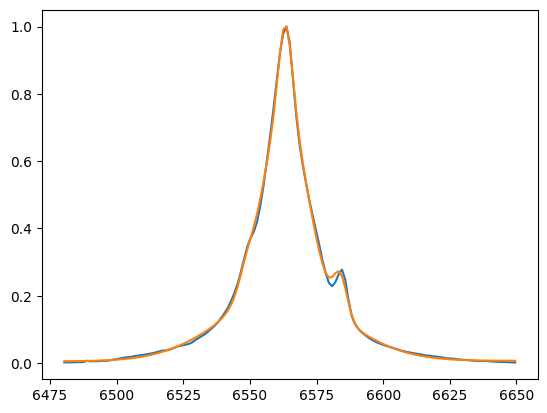

In [22]:
# Fit a two Gaussian model to NII & Halpha
ha_c1_2G = np.zeros((Ny_muse,Nx_muse))
ha_c2_2G = np.zeros((Ny_muse,Nx_muse))
ha_wave1_2G = np.zeros((Ny_muse,Nx_muse))
ha_sig1_2G = np.zeros((Ny_muse,Nx_muse))
ha_flux1_2G = np.zeros((Ny_muse,Nx_muse))
nii6585_flux1_2G = np.zeros((Ny_muse,Nx_muse))
ha_wave2_2G = np.zeros((Ny_muse,Nx_muse))
ha_sig2_2G = np.zeros((Ny_muse,Nx_muse))
ha_flux2_2G = np.zeros((Ny_muse,Nx_muse))
nii6585_flux2_2G = np.zeros((Ny_muse,Nx_muse))
ha_BLR_wave_2G = np.zeros((Ny_muse,Nx_muse))
ha_BLR_sig_2G = np.zeros((Ny_muse,Nx_muse))
ha_BLR_flux_2G = np.zeros((Ny_muse,Nx_muse))
bic_ha_2G = np.zeros((Ny_muse, Nx_muse))

model_ha2G = Model(func_nii_ha_2G)
params_ha2G = Parameters()
params_ha2G.add('c1', value=0)
params_ha2G.add('c2', value=0)
params_ha2G.add('mean1', value=6562, min=6555, max=6575)
params_ha2G.add('sig1', value=2, min=0)
params_ha2G.add('peak1_ha', value=1, min=0)
params_ha2G.add('peak1_nii', value=1, min=0)

params_ha2G.add('mean2', value=6562, min=6555, max=6575)
params_ha2G.add('sig2', value=8, min=0)
params_ha2G.add('peak2_ha', value=0.5, min=0)
params_ha2G.add('peak2_nii', value=0.5, min=0)

params_ha2G.add('mean_blr', value=6562, min=6555, max=6575)
params_ha2G.add('sig_blr', value=22, min=0)
params_ha2G.add('peak_blr', value=0.1, min=0)

def fit_pixel_ha_2G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_ha[:,j,i]+cube_ha[:,j-1,i]+cube_ha[:,j+1,i]+cube_ha[:,j,i-1]+cube_ha[:,j,i+1])/5 
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_ha = model_ha2G.fit(spec_norm, params_ha2G, x=wl_ha, weights=1)
    return (
        fit_ha.params["c1"].value,
        fit_ha.params["c2"].value,
        fit_ha.params["mean1"].value,
        fit_ha.params["sig1"].value,
        np.sqrt(2*np.pi)*fit_ha.params["sig1"].value*fit_ha.params["peak1_ha"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_ha.params["sig1"].value*fit_ha.params["peak1_nii"].value*1e-20*np.max(spec),
        fit_ha.params["mean2"].value,
        fit_ha.params["sig2"].value,
        np.sqrt(2*np.pi)*fit_ha.params["sig2"].value*fit_ha.params["peak2_ha"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_ha.params["sig2"].value*fit_ha.params["peak2_nii"].value*1e-20*np.max(spec),
        fit_ha.params["mean_blr"].value,
        fit_ha.params["sig_blr"].value,
        np.sqrt(2*np.pi)*fit_ha.params["sig_blr"].value*fit_ha.params["peak_blr"].value*1e-20*np.max(spec),
        fit_ha.bic
    )

fit_Ha_2G_models = True
if fit_Ha_2G_models == True:
    # Parallel with tqdm
    results_ha_2G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_ha_2G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

# Visualise the spectral fit using this section
visualise_Ha_2G = True
if visualise_Ha_2G == True:
    i,j = 171, 165
    spec = (cube_ha[:,j,i]+cube_ha[:,j-1,i]+cube_ha[:,j+1,i]+cube_ha[:,j,i-1]+cube_ha[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_ha = model_ha2G.fit(spec_norm, params_ha2G, x=wl_ha, weights=1)
    plt.plot(wl_ha, spec_norm)
    plt.plot(wl_ha, fit_ha.best_fit)

In [23]:
# Fill the output arrays
idx = 0
for j, i in coords:
    ha_c1_2G[j,i],ha_c2_2G[j,i],ha_wave1_2G[j,i],ha_sig1_2G[j,i],ha_flux1_2G[j,i],nii6585_flux1_2G[j,i],ha_wave2_2G[j,i],ha_sig2_2G[j,i], ha_flux2_2G[j,i],nii6585_flux2_2G[j,i],ha_BLR_wave_2G[j,i],ha_BLR_sig_2G[j,i],ha_BLR_flux_2G[j,i],bic_ha_2G[j,i] = results_ha_2G[idx]
    idx += 1

## Fit SII doublet

In [24]:
filt_sii = np.where((wl_DR>6690)&(wl_DR<6755))
wl_sii = wl_DR[filt_sii]
cube_sii = contsub_cube[filt_sii,:,:][0,:,:,:]

Fitting pixels: 100%|█████████████████| 103683/103683 [2:29:43<00:00, 11.54it/s]


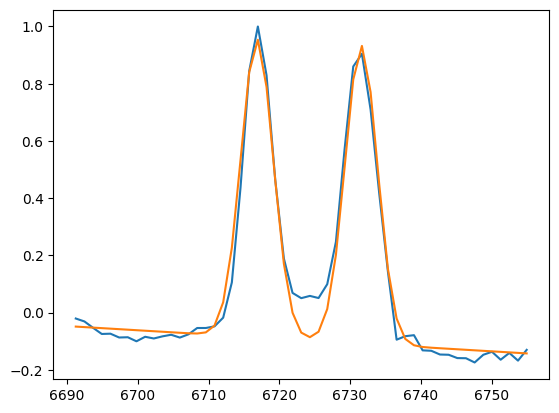

In [25]:
# Fit a one Gaussian model to the SII doublet
sii_c1_1G = np.zeros((Ny_muse,Nx_muse))
sii_c2_1G = np.zeros((Ny_muse,Nx_muse))
sii6716_wave_1G = np.zeros((Ny_muse,Nx_muse))
sii6716_sig_1G = np.zeros((Ny_muse,Nx_muse))
sii6716_flux_1G = np.zeros((Ny_muse,Nx_muse))
sii6731_flux_1G = np.zeros((Ny_muse,Nx_muse))
bic_sii_1G = np.zeros((Ny_muse, Nx_muse))

model_sii1G = Model(func_sii)
params_sii1G = Parameters()
params_sii1G.add('c1', value=0)
params_sii1G.add('c2', value=0)
params_sii1G.add('mean', value=6716, min=6706, max=6724)
params_sii1G.add('sig', value=2, min=0)
params_sii1G.add('peak_sii6716', value=1, min=0)
params_sii1G.add('peak_sii6731', value=1, min=0)

def fit_pixel_sii_1G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_sii[:,j,i]+cube_sii[:,j-1,i]+cube_sii[:,j+1,i]+cube_sii[:,j,i-1]+cube_sii[:,j,i+1])/5 
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_sii = model_sii1G.fit(spec_norm, params_sii1G, x=wl_sii, weights=1)
    return (
        fit_sii.params["c1"].value,
        fit_sii.params["c2"].value,
        fit_sii.params["mean"].value,
        fit_sii.params["sig"].value,
        np.sqrt(2*np.pi)*fit_sii.params["sig"].value*fit_sii.params["peak_sii6716"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_sii.params["sig"].value*fit_sii.params["peak_sii6731"].value*1e-20*np.max(spec),
        fit_sii.bic
    )

fit_sii_1G_models = True
if fit_sii_1G_models == True:
    # Parallel with tqdm
    results_sii_1G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_sii_1G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

# Visualise the spectral fit using this section
visualise_sii_1G = True
if visualise_sii_1G == True:
    i,j = 172, 162
    spec = (cube_sii[:,j,i]+cube_sii[:,j-1,i]+cube_sii[:,j+1,i]+cube_sii[:,j,i-1]+cube_sii[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_sii = model_sii1G.fit(spec_norm, params_sii1G, x=wl_sii, weights=1)
    plt.plot(wl_sii, spec_norm)
    plt.plot(wl_sii, fit_sii.best_fit)

In [26]:
# Fill the output arrays
idx = 0
for j, i in coords:
    sii_c1_1G[j,i], sii_c2_1G[j,i], sii6716_wave_1G[j,i],sii6716_sig_1G[j,i],sii6716_flux_1G[j,i], sii6731_flux_1G[j,i],bic_sii_1G[j,i] = results_sii_1G[idx]
    idx += 1

Fitting pixels: 100%|████████████████| 103683/103683 [17:06:31<00:00,  1.68it/s]


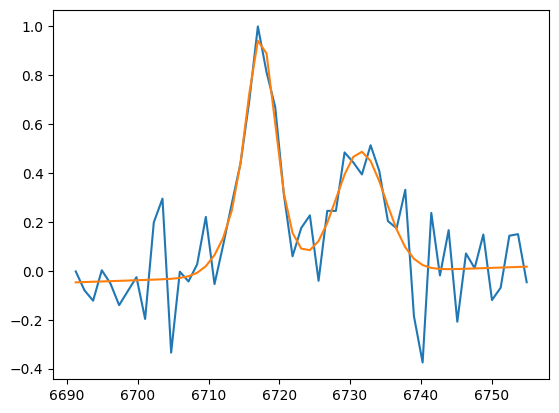

In [27]:
# Fit a one Gaussian model to the SII doublet
sii_c1_2G = np.zeros((Ny_muse,Nx_muse))
sii_c2_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_wave1_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_sig1_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_flux1_2G = np.zeros((Ny_muse,Nx_muse))
sii6731_flux1_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_wave2_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_sig2_2G = np.zeros((Ny_muse,Nx_muse))
sii6716_flux2_2G = np.zeros((Ny_muse,Nx_muse))
sii6731_flux2_2G = np.zeros((Ny_muse,Nx_muse))
bic_sii_2G = np.zeros((Ny_muse, Nx_muse))

model_sii2G = Model(func_sii_2G)
params_sii2G = Parameters()
params_sii2G.add('c1', value=0)
params_sii2G.add('c2', value=0)
params_sii2G.add('mean1', value=6716, min=6706, max=6724)
params_sii2G.add('sig1', value=2, min=0)
params_sii2G.add('peak1_sii6716', value=1, min=0)
params_sii2G.add('peak1_sii6731', value=1, min=0)
params_sii2G.add('mean2', value=6716, min=6706, max=6724)
params_sii2G.add('sig2', value=7, min=0)
params_sii2G.add('peak2_sii6716', value=1, min=0)
params_sii2G.add('peak2_sii6731', value=1, min=0)

def fit_pixel_sii_2G(j, i):
    # You can remove the following line if you wish. This is a running mean of neighbouring 5 pixels to increase the overall SNR of the cube
    # This does not compromise with the PSF or resolution of the observations
    spec = (cube_sii[:,j,i]+cube_sii[:,j-1,i]+cube_sii[:,j+1,i]+cube_sii[:,j,i-1]+cube_sii[:,j,i+1])/5 
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_sii = model_sii2G.fit(spec_norm, params_sii2G, x=wl_sii, weights=1)
    return (
        fit_sii.params["c1"].value,
        fit_sii.params["c2"].value,
        fit_sii.params["mean1"].value,
        fit_sii.params["sig1"].value,
        np.sqrt(2*np.pi)*fit_sii.params["sig1"].value*fit_sii.params["peak1_sii6716"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_sii.params["sig1"].value*fit_sii.params["peak1_sii6731"].value*1e-20*np.max(spec),
        fit_sii.params["mean2"].value,
        fit_sii.params["sig2"].value,
        np.sqrt(2*np.pi)*fit_sii.params["sig2"].value*fit_sii.params["peak2_sii6716"].value*1e-20*np.max(spec),
        np.sqrt(2*np.pi)*fit_sii.params["sig2"].value*fit_sii.params["peak2_sii6731"].value*1e-20*np.max(spec),
        fit_sii.bic
    )

fit_sii_2G_models = True
if fit_sii_2G_models == True:
    # Parallel with tqdm
    results_sii_2G = Parallel(n_jobs=-1, prefer="threads")(
        delayed(fit_pixel_sii_2G)(j, i)
        for j, i in tqdm(coords, desc="Fitting pixels")
    )

# Visualise the spectral fit using this section
visualise_sii_2G = True
if visualise_sii_2G == True:
    i,j = 152, 172
    spec = (cube_sii[:,j,i]+cube_sii[:,j-1,i]+cube_sii[:,j+1,i]+cube_sii[:,j,i-1]+cube_sii[:,j,i+1])/5
    spec = np.nan_to_num(spec, nan=0.0)
    spec_norm = spec / np.max(spec) if np.max(spec) != 0 else spec
    fit_sii = model_sii2G.fit(spec_norm, params_sii2G, x=wl_sii, weights=1)
    plt.plot(wl_sii, spec_norm)
    plt.plot(wl_sii, fit_sii.best_fit)

In [28]:
# Fill the output arrays
idx = 0
for j, i in coords:
    sii_c1_2G[j,i], sii_c2_2G[j,i], sii6716_wave1_2G[j,i],sii6716_sig1_2G[j,i],sii6716_flux1_2G[j,i], sii6731_flux1_2G[j,i],sii6716_wave2_2G[j,i],sii6716_sig2_2G[j,i],sii6716_flux2_2G[j,i], sii6731_flux2_2G[j,i],bic_sii_2G[j,i] = results_sii_2G[idx]
    idx += 1

## Save as fits file

In [29]:
# Create a Primary HDU object
primary_hdu = fits.PrimaryHDU(data=None)

# Create Image HDUs for the extensions
oiii_c1_1G_hdu = fits.ImageHDU(data=oiii_c1_1G,name='oiii_c1_1G')
oiii_c2_1G_hdu = fits.ImageHDU(data=oiii_c2_1G,name='oiii_c2_1G')
oiii_wave_1G_hdu = fits.ImageHDU(data=oiii_wave_1G,name='oiii_wave_1G')
oiii_sig_1G_hdu = fits.ImageHDU(data=oiii_sig_1G,name='oiii_sig_1G')
oiii_flux_1G_hdu = fits.ImageHDU(data=oiii_flux_1G,name='oiii_flux_1G')
Hb_flux_1G_hdu = fits.ImageHDU(data=Hb_flux_1G,name='Hb_flux_1G')
bic_oiii_1G_hdu = fits.ImageHDU(data=bic_oiii_1G,name='bic_oiii_1G')
ha_c1_1G_hdu = fits.ImageHDU(data=ha_c1_1G,name='ha_c1_1G')
ha_c2_1G_hdu = fits.ImageHDU(data=ha_c2_1G,name='ha_c2_1G')
ha_wave_1G_hdu = fits.ImageHDU(data=ha_wave_1G,name='ha_wave_1G')
ha_sig_1G_hdu = fits.ImageHDU(data=ha_sig_1G,name='ha_sig_1G')
ha_flux_1G_hdu = fits.ImageHDU(data=ha_flux_1G,name='ha_flux_1G')
nii6585_flux_1G_hdu = fits.ImageHDU(data=nii6585_flux_1G,name='nii6585_flux_1G')
bic_ha_1G_hdu = fits.ImageHDU(data=bic_ha_1G,name='bic_ha_1G')
sii_c1_1G_hdu = fits.ImageHDU(data=sii_c1_1G,name='sii_c1_1G')
sii_c2_1G_hdu = fits.ImageHDU(data=sii_c2_1G,name='sii_c2_1G')
sii6716_wave_1G_hdu = fits.ImageHDU(data=sii6716_wave_1G,name='sii6716_wave_1G')
sii6716_sig_1G_hdu = fits.ImageHDU(data=sii6716_sig_1G,name='sii6716_sig_1G')
sii6716_flux_1G_hdu = fits.ImageHDU(data=sii6716_flux_1G,name='sii6716_flux_1G')
sii6731_flux_1G_hdu = fits.ImageHDU(data=sii6731_flux_1G,name='sii6731_flux_1G')
bic_sii_1G_hdu = fits.ImageHDU(data=bic_sii_1G,name='bic_sii_1G')

oiii_c1_2G_hdu = fits.ImageHDU(data=oiii_c1_2G,name='oiii_c1_2G')
oiii_c2_2G_hdu = fits.ImageHDU(data=oiii_c2_2G,name='oiii_c2_2G')
oiii_wave1_2G_hdu = fits.ImageHDU(data=oiii_wave1_2G,name='oiii_wave1_2G')
oiii_sig1_2G_hdu = fits.ImageHDU(data=oiii_sig1_2G,name='oiii_sig1_2G')
oiii_flux1_2G_hdu = fits.ImageHDU(data=oiii_flux1_2G,name='oiii_flux1_2G')
Hb_flux1_2G_hdu = fits.ImageHDU(data=Hb_flux1_2G,name='Hb_flux1_2G')
oiii_wave2_2G_hdu = fits.ImageHDU(data=oiii_wave2_2G,name='oiii_wave2_2G')
oiii_sig2_2G_hdu = fits.ImageHDU(data=oiii_sig2_2G,name='oiii_sig2_2G')
oiii_flux2_2G_hdu = fits.ImageHDU(data=oiii_flux2_2G,name='oiii_flux2_2G')
Hb_flux2_2G_hdu = fits.ImageHDU(data=Hb_flux2_2G,name='Hb_flux2_2G')
Hb_blr_wave_2G_hdu = fits.ImageHDU(data=Hb_blr_wave_2G,name='Hb_blr_wave_2G')
Hb_blr_sig_2G_hdu = fits.ImageHDU(data=Hb_blr_sig_2G,name='Hb_blr_sig_2G')
Hb_blr_flux_2G_hdu = fits.ImageHDU(data=Hb_blr_flux_2G,name='Hb_blr_flux_2G')
bic_oiii_2G_hdu = fits.ImageHDU(data=bic_oiii_2G,name='bic_oiii_2G')
ha_c1_2G_hdu = fits.ImageHDU(data=ha_c1_2G,name='ha_c1_2G')
ha_c2_2G_hdu = fits.ImageHDU(data=ha_c2_2G,name='ha_c2_2G')
ha_wave1_2G_hdu = fits.ImageHDU(data=ha_wave1_2G,name='ha_wave1_2G')
ha_sig1_2G_hdu = fits.ImageHDU(data=ha_sig1_2G,name='ha_sig1_2G')
ha_flux1_2G_hdu = fits.ImageHDU(data=ha_flux1_2G,name='ha_flux1_2G')
nii6585_flux1_2G_hdu = fits.ImageHDU(data=nii6585_flux1_2G,name='nii6585_flux1_2G')
ha_wave2_2G_hdu = fits.ImageHDU(data=ha_wave2_2G,name='ha_wave2_2G')
ha_sig2_2G_hdu = fits.ImageHDU(data=ha_sig2_2G,name='ha_sig2_2G')
ha_flux2_2G_hdu = fits.ImageHDU(data=ha_flux2_2G,name='ha_flux2_2G')
nii6585_flux2_2G_hdu = fits.ImageHDU(data=nii6585_flux2_2G,name='nii6585_flux2_2G')
ha_BLR_wave_2G_hdu = fits.ImageHDU(data=ha_BLR_wave_2G,name='ha_BLR_wave_2G')
ha_BLR_sig_2G_hdu = fits.ImageHDU(data=ha_BLR_sig_2G,name='ha_BLR_sig_2G')
ha_BLR_flux_2G_hdu = fits.ImageHDU(data=ha_BLR_flux_2G,name='ha_BLR_flux_2G')
bic_ha_2G_hdu = fits.ImageHDU(data=bic_ha_2G,name='bic_ha_2G')
sii_c1_2G_hdu = fits.ImageHDU(data=sii_c1_2G,name='sii_c1_2G')
sii_c2_2G_hdu = fits.ImageHDU(data=sii_c2_2G,name='sii_c2_2G')
sii6716_wave1_2G_hdu = fits.ImageHDU(data=sii6716_wave1_2G,name='sii6716_wave1_2G')
sii6716_sig1_2G_hdu = fits.ImageHDU(data=sii6716_sig1_2G,name='sii6716_sig1_2G')
sii6716_flux1_2G_hdu = fits.ImageHDU(data=sii6716_flux1_2G,name='sii6716_flux1_2G')
sii6731_flux1_2G_hdu = fits.ImageHDU(data=sii6731_flux1_2G,name='sii6731_flux1_2G')
sii6716_wave2_2G_hdu = fits.ImageHDU(data=sii6716_wave2_2G,name='sii6716_wave2_2G')
sii6716_sig2_2G_hdu = fits.ImageHDU(data=sii6716_sig2_2G,name='sii6716_sig2_2G')
sii6716_flux2_2G_hdu = fits.ImageHDU(data=sii6716_flux2_2G,name='sii6716_flux2_2G')
sii6731_flux2_2G_hdu = fits.ImageHDU(data=sii6731_flux2_2G,name='sii6731_flux2_2G')
bic_sii_2G_hdu = fits.ImageHDU(data=bic_sii_2G,name='bic_sii_2G')

# Create an HDUList to contain all HDUs
hdulist = fits.HDUList([primary_hdu, oiii_c1_1G_hdu,oiii_c2_1G_hdu,oiii_wave_1G_hdu,oiii_sig_1G_hdu,oiii_flux_1G_hdu,
    Hb_flux_1G_hdu,bic_oiii_1G_hdu,ha_c1_1G_hdu,ha_c2_1G_hdu,ha_wave_1G_hdu,ha_sig_1G_hdu,ha_flux_1G_hdu, nii6585_flux_1G_hdu,
    bic_ha_1G_hdu,sii_c1_1G_hdu,sii_c2_1G_hdu,sii6716_wave_1G_hdu,sii6716_sig_1G_hdu,sii6716_flux_1G_hdu,sii6731_flux_1G_hdu,
    bic_sii_1G_hdu,
    oiii_c1_2G_hdu,oiii_c2_2G_hdu,oiii_wave1_2G_hdu,oiii_sig1_2G_hdu,oiii_flux1_2G_hdu,Hb_flux1_2G_hdu,oiii_wave2_2G_hdu,
    oiii_sig2_2G_hdu,oiii_flux2_2G_hdu,Hb_flux2_2G_hdu,Hb_blr_wave_2G_hdu,Hb_blr_sig_2G_hdu,Hb_blr_flux_2G_hdu,bic_oiii_2G_hdu,
    ha_c1_2G_hdu,ha_c2_2G_hdu,ha_wave1_2G_hdu,ha_sig1_2G_hdu,ha_flux1_2G_hdu,nii6585_flux1_2G_hdu,ha_wave2_2G_hdu,ha_sig2_2G_hdu,
    ha_flux2_2G_hdu,nii6585_flux2_2G_hdu,ha_BLR_wave_2G_hdu,ha_BLR_sig_2G_hdu,ha_BLR_flux_2G_hdu,bic_ha_2G_hdu,sii_c1_2G_hdu,
    sii_c2_2G_hdu,sii6716_wave1_2G_hdu,sii6716_sig1_2G_hdu,sii6716_flux1_2G_hdu,sii6731_flux1_2G_hdu,sii6716_wave2_2G_hdu,
    sii6716_sig2_2G_hdu,sii6716_flux2_2G_hdu,sii6731_flux2_2G_hdu,bic_sii_2G_hdu])

# Write the HDUList to a new FITS file
hdulist.writeto('MUSE_maps.fits', overwrite=True)

In [30]:
Hb_blr_flux_2G

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])